# Experiments for MNIST Dataset

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('device', device)
else:
    device = torch.device("cpu")
    print('device', device)

device cuda:0


In [5]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best guarantee of interpretable task decompositions
from moe_models.moe_expectation_model import moe_expectation_model
from helper.moe_models import cross_entropy_loss

device cuda:0
device cuda:0


### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

## Load MNIST dataset

In [6]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures/test'
model_path = '../models/test'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [7]:
import torchvision.transforms as transforms

# transforms: Convert PIL image to tensors and normalize
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [8]:
# Set train and test size
trainsize = 10048
testsize = 2000

In [9]:
# Load and split data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=transform)

batch_size = 64
# dataloaders
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(0,trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(0,testsize)),
                                         batch_size=2000,
                                         shuffle=False)
num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))

Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


In [10]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Data samples


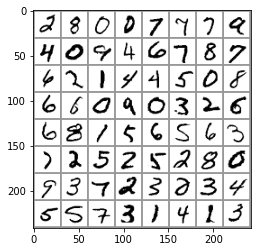

In [11]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# create grid of images
img_grid = torchvision.utils.make_grid(images)

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


## Define expert and gate networks

In [12]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, masks, num_classes, output):
        super(expert_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)
        self.fc1 = nn.Linear(in_features=1*12*12, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=10) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=10, out_features=num_classes)
        
        self.num_classes = num_classes
        self.masks = masks
        self.output = output
        
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*12*12)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
        
        if not self.masks is None:
            mask = torch.zeros(t.shape[0],self.num_classes)
            for m, i in zip(self.masks, range(self.output)):
                mask[:,m] = t[:,i] 
            return mask
        
        return t

In [13]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts, num_classes):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)

        self.fc1 = nn.Linear(in_features=1*12*12, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=num_experts)
        self.num_experts = num_experts
        self.num_classes = num_classes
        self.count = 0

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*12*12)
        if not y is None:
            t = torch.cat((t, torch.flatten(y, start_dim=1)), dim=1)
            self.fc1 = nn.Linear(in_features=1*12*12+(self.num_experts* self.num_classes), out_features=15)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1)
        return t


In [14]:
# create a set of experts
def experts(num_experts, masks, total_num_classes, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(masks[i], total_num_classes, num_classes[i]))
    return nn.ModuleList(models)

## Initialize configurations and helper functions

In [15]:
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

In [16]:
# gate covariant shift regularization flag 
w_importance = 0.0 
w_ortho = 0.0

def generate_plot_file(dataset, specific):
    plot_file = dataset
    if w_importance > 0:
        plot_file += '_importance_'+str(w_importance)
    if w_ortho > 0:
        plot_file += '_ortho_'+str(w_ortho)
    plot_file += '_'+specific
    
    return plot_file

In [17]:
def classes_per_expert_str(classes_per_expert):
    buffer_str = ''
    for labels in classes_per_expert:
        buffer = "_".join(str(labels).replace('[','').replace(']','').replace(',','_').replace(" ",'')).replace('_','')
        buffer_str += buffer+'_'
    buffer_str = buffer_str.strip('_')
    return buffer_str

## Experiment 1: Train MoE expectation model with importance

In [20]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_scratch'

In [21]:
total_experts = 5

In [22]:
num_epochs = 20

In [23]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [22]:
# Train models model_1, model_2 and model_3 for 10 runs
n_run_models_1 = []
for w_importance in w_importance_range:
    print('w_importance', w_importance)
    models = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
        }

    # Build model with un-trained experts
    for key, val in models.items():
        print('Model:', key, total_experts, 'Experts')
        print('Building model with un-trained experts')
        # copy and save the expert models to save the parameters
        expert_models = experts(total_experts, [None]*total_experts, num_classes, 
                                     [num_classes]*total_experts).to(device)

        gate_model = gate_layers(total_experts, num_classes).to(device)

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                                 experts=expert_models, gate=gate_model)

        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))

        optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                  lr=0.001, momentum=0.9)
        hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, 
                               w_importance=w_importance,
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    n_run_models_1.append(models)

# Save all the trained models
plot_file = generate_plot_file(model_1, 'importance_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')
print(plot_file)
torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))

w_importance 0.0
Model: moe_expectation_model 5 Experts
Building model with un-trained experts
model params: 31772
epoch 0 training loss 1.07 , training accuracy 0.67 , test accuracy 0.75


KeyboardInterrupt: 

### Experiment 1 - Results

mnist_scratch_importance_1.0_10_5_models.pt
Model: mnist_scratch_importance_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


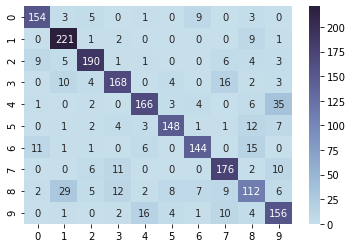


Experts used by the gate for classification of each digit


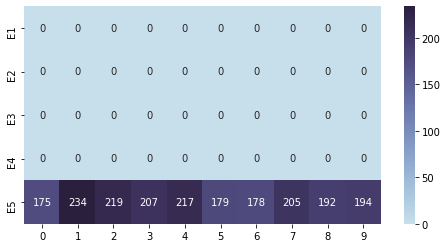

Model: mnist_scratch_importance_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


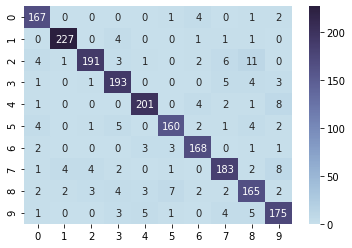


Experts used by the gate for classification of each digit


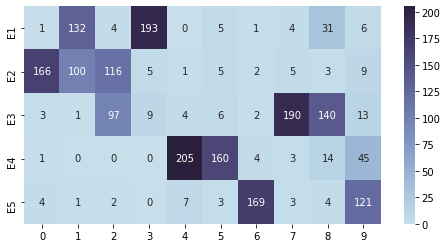

Model: mnist_scratch_importance_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


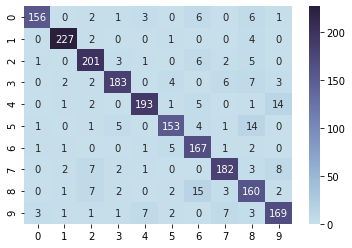


Experts used by the gate for classification of each digit


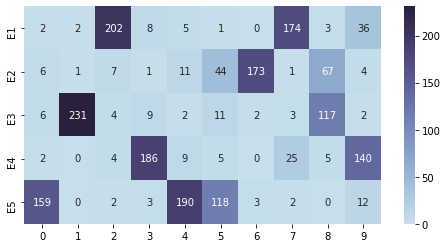

Model: mnist_scratch_importance_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


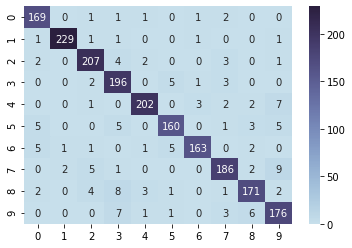


Experts used by the gate for classification of each digit


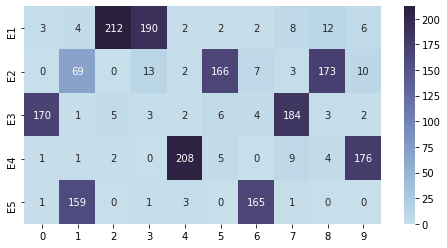

Model: mnist_scratch_importance_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


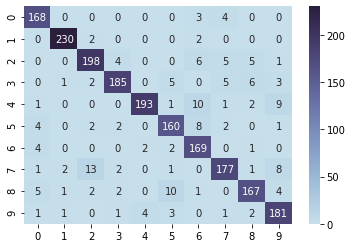


Experts used by the gate for classification of each digit


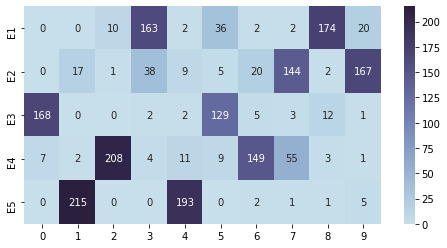

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model_1 = 'mnist_scratch'
w_importance = 1.0
m = model_1
total_experts = 5
plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_models.pt')
models_scratch = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
print(plot_file)

for model, w_importance in zip(models_scratch, w_importance_range):
    # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
    # model you build above
    print('Model:', plot_file)

    # Plotting for the model of the first run
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        for images, labels in testloader:
            fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
            images, labels = images.to(device), labels.to(device)
            moe_model = e_val['experts'][total_experts]['model']

            # predict the classes for test data
            pred = moe_model(images)
            pred_labels = torch.argmax(pred, dim=1)

            expert_outputs = moe_model.expert_outputs
            gate_outputs = moe_model.gate_outputs

            # plot the confusion matrix
            print('\nConfusion matrix of predictions of the MNIST test data by MoE expectation model')
            sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1, cmap=cmap, fmt='d')
            image_file = generate_plot_file(m, 'conf_mat_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig1.savefig(os.path.join(fig_path, image_file))
            plt.show()

            fig2,ax2 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

            # get the experts selected by the gate for each sample
            pred_gate_labels = torch.argmax(gate_outputs, dim=1)

            # plot the expert selection table
            print('\nExperts used by the gate for classification of each digit')
            class_expert_table = np.asarray([[0] * num_classes]*total_experts)
            for label, expert in zip(labels, pred_gate_labels):
                class_expert_table[expert,label] += 1
            sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d', ax=ax2)

            image_file = generate_plot_file(m, 'class_expert_table_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig2.savefig(os.path.join(fig_path, image_file))
            plt.show()

## Experiment 2: Train MoE expectation model with different expert output orthogonality

In [25]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_scratch'

In [26]:
total_experts = 5

In [27]:
num_epochs = 20

In [28]:
w_ortho_range = [i * 0.2 for i in range(1,6)]
w_ortho_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [22]:
# Train models model_4, model_5 and model_6 for the different splits of the digits shown above.
n_split_models_1 = []
w_importance = 0.0
for w_ortho in w_ortho_range:
    print('w_ortho', w_ortho)
    models = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
        }

    for key, val in models.items():
        print('Model:', key, total_experts, 'Experts')
        print('Building model with pre-trained experts')

        expert_models = experts(total_experts, [None]*total_experts, num_classes, 
                                     [num_classes]*total_experts).to(device)

        gate_model = gate_layers(total_experts, num_classes).to(device)


        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model)

        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))
        optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                  lr=0.001, momentum=0.9)
        hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, 
                               w_ortho=w_ortho,
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    n_split_models_1.append(models)

plot_file = generate_plot_file(model_1, str(num_classes)+'_'+str(total_experts)+'_models.pt')
torch.save(n_split_models_1,open(os.path.join(model_path, plot_file),'wb'))
print(plot_file)

w_ortho 0.2
Model: moe_expectation_model 5 Experts
Building model with pre-trained experts
model params: 31772
epoch 0 training loss 1.17 , training accuracy 0.59 , test accuracy 0.59
epoch 1 training loss 0.75 , training accuracy 0.73 , test accuracy 0.74
epoch 2 training loss 0.56 , training accuracy 0.83 , test accuracy 0.79
epoch 3 training loss 0.51 , training accuracy 0.85 , test accuracy 0.80
epoch 4 training loss 0.45 , training accuracy 0.87 , test accuracy 0.80
epoch 5 training loss 0.46 , training accuracy 0.86 , test accuracy 0.78
epoch 6 training loss 0.46 , training accuracy 0.87 , test accuracy 0.83
epoch 7 training loss 0.40 , training accuracy 0.89 , test accuracy 0.82
epoch 8 training loss 0.39 , training accuracy 0.89 , test accuracy 0.81
epoch 9 training loss 0.37 , training accuracy 0.90 , test accuracy 0.82
epoch 10 training loss 0.35 , training accuracy 0.90 , test accuracy 0.83
epoch 11 training loss 0.32 , training accuracy 0.91 , test accuracy 0.82
epoch 12 tr

###  Experiment 2 - Results

mnist_scratch_ortho_1.0_10_5_models.pt
Model: mnist_scratch_ortho_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


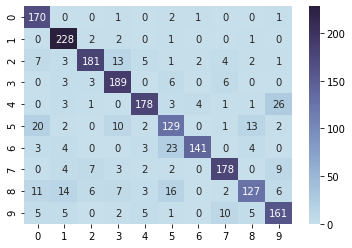


Experts used by the gate for classification of each digit


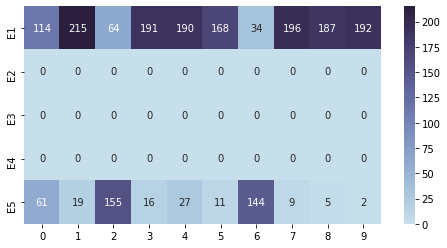

Model: mnist_scratch_ortho_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


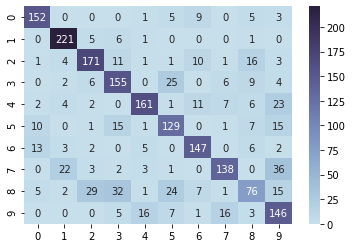


Experts used by the gate for classification of each digit


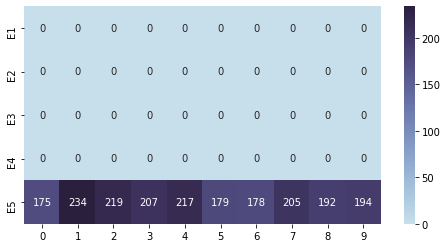

Model: mnist_scratch_ortho_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


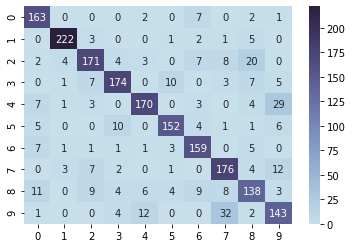


Experts used by the gate for classification of each digit


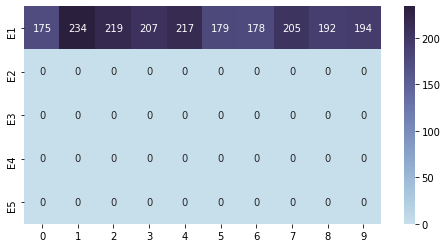

Model: mnist_scratch_ortho_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


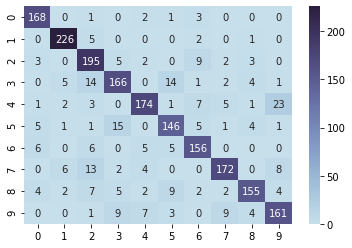


Experts used by the gate for classification of each digit


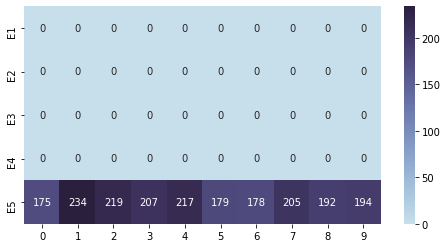

Model: mnist_scratch_ortho_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


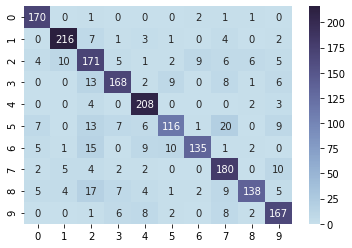


Experts used by the gate for classification of each digit


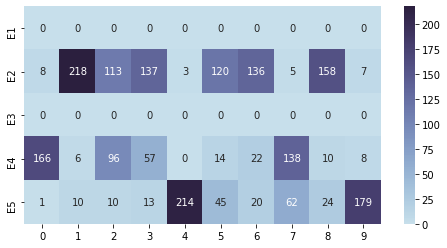

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model_1 = 'mnist_scratch'
w_importance = 0.0
w_ortho = 1.0
m = model_1
total_experts = 5
plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_models.pt')
models_scratch = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
print(plot_file)

for model, w_ortho in zip(models_scratch, w_ortho_range):
    # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
    # model you build above
    print('Model:', plot_file)

    # Plotting for the model of the first run
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        for images, labels in testloader:
            fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
            images, labels = images.to(device), labels.to(device)
            moe_model = e_val['experts'][total_experts]['model']

            # predict the classes for test data
            pred = moe_model(images)
            pred_labels = torch.argmax(pred, dim=1)

            expert_outputs = moe_model.expert_outputs
            gate_outputs = moe_model.gate_outputs

            # plot the confusion matrix
            print('\nConfusion matrix of predictions of the MNIST test data by MoE expectation model')
            sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1, cmap=cmap, fmt='d')
            image_file = generate_plot_file(m, 'conf_mat_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig1.savefig(os.path.join(fig_path, image_file))
            plt.show()

            fig2,ax2 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

            # get the experts selected by the gate for each sample
            pred_gate_labels = torch.argmax(gate_outputs, dim=1)

            # plot the expert selection table
            print('\nExperts used by the gate for classification of each digit')
            class_expert_table = np.asarray([[0] * num_classes]*total_experts)
            for label, expert in zip(labels, pred_gate_labels):
                class_expert_table[expert,label] += 1
            sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d', ax=ax2)

            image_file = generate_plot_file(m, 'class_expert_table_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig2.savefig(os.path.join(fig_path, image_file))
            plt.show()

## Experiment 3: Train MoE expectation model with different expert output orthogonality

In [30]:
w_importance_range = [0.2,0.6,1.0]
w_ortho_range = [0.2,0.6,1.0]

In [34]:
# Train models model_4, model_5 and model_6 for the different splits of the digits shown above.
n_split_models_1 = []

for w_importance in w_importance_range:
    for w_ortho in w_ortho_range:
        print('w_importance', w_importance)
        print('w_ortho', w_ortho)
        models = {
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
            }

        for key, val in models.items():
            print('Model:', key, total_experts, 'Experts')
            print('Building model with pre-trained experts')

            expert_models = experts(total_experts, [None]*total_experts, num_classes, 
                                         [num_classes]*total_experts).to(device)

            gate_model = gate_layers(total_experts, num_classes).to(device)


            moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                     experts=expert_models, gate=gate_model)

            params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
            print('model params:', sum(params))
            optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                      lr=0.001, momentum=0.9)
            hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, 
                                   w_importance = w_importance, w_ortho=w_ortho,
                                   accuracy=accuracy, epochs=num_epochs)
            val['experts'][total_experts] = {'model':moe_model, 'history':hist}

        n_split_models_1.append(models)

plot_file = generate_plot_file(model_1, str(num_classes)+'_'+str(total_experts)+'_models.pt')
torch.save(n_split_models_1,open(os.path.join(model_path, plot_file),'wb'))
print(plot_file)

w_importance 0.2
w_ortho 0.2
Model: moe_expectation_model 5 Experts
Building model with pre-trained experts
model params: 31772
epoch 0 training loss 0.79 , training accuracy 0.79 , test accuracy 0.87
epoch 1 training loss 0.32 , training accuracy 0.92 , test accuracy 0.88
epoch 2 training loss 0.26 , training accuracy 0.94 , test accuracy 0.90
epoch 3 training loss 0.22 , training accuracy 0.95 , test accuracy 0.91
epoch 4 training loss 0.18 , training accuracy 0.96 , test accuracy 0.91
epoch 5 training loss 0.17 , training accuracy 0.97 , test accuracy 0.92
epoch 6 training loss 0.16 , training accuracy 0.97 , test accuracy 0.91
epoch 7 training loss 0.14 , training accuracy 0.98 , test accuracy 0.90
epoch 8 training loss 0.14 , training accuracy 0.98 , test accuracy 0.91
epoch 9 training loss 0.14 , training accuracy 0.98 , test accuracy 0.91
epoch 10 training loss 0.12 , training accuracy 0.98 , test accuracy 0.92
epoch 11 training loss 0.12 , training accuracy 0.98 , test accuracy

mnist_scratch_importance_1.0_ortho_1.0_10_5_models.pt
0 0
0.2 0.2
Model: mnist_scratch_importance_1.0_ortho_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


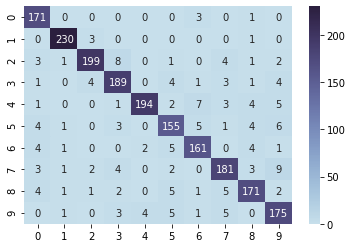

mnist_scratch_importance_0.2_ortho_0.2_conf_mat_run_10_5_experts.png

Experts used by the gate for classification of each digit


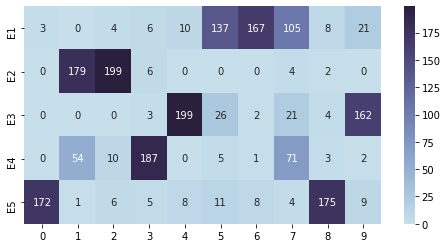

mnist_scratch_importance_0.2_ortho_0.2_class_expert_table_run_10_5_experts.png


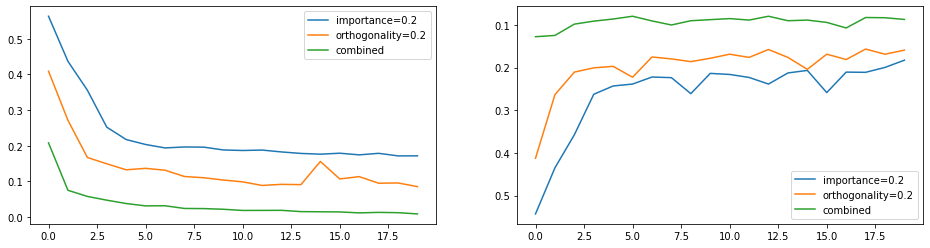

0 1
0.2 0.6
Model: mnist_scratch_importance_1.0_ortho_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


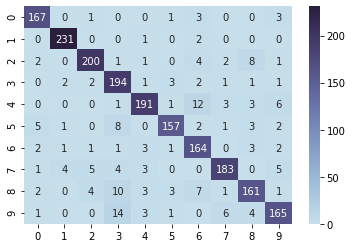

mnist_scratch_importance_0.2_ortho_0.6_conf_mat_run_10_5_experts.png

Experts used by the gate for classification of each digit


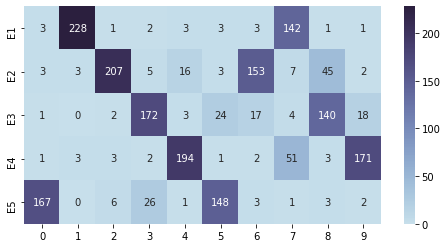

mnist_scratch_importance_0.2_ortho_0.6_class_expert_table_run_10_5_experts.png


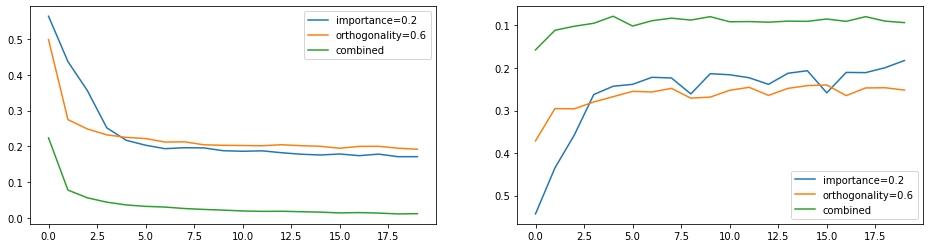

0 2
0.2 1.0
Model: mnist_scratch_importance_1.0_ortho_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


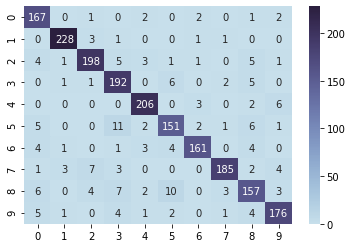

mnist_scratch_importance_0.2_ortho_1.0_conf_mat_run_10_5_experts.png

Experts used by the gate for classification of each digit


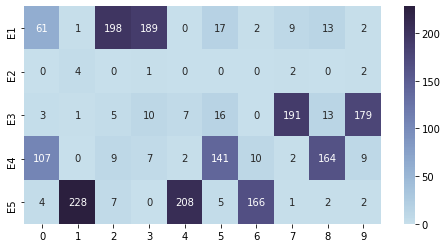

mnist_scratch_importance_0.2_ortho_1.0_class_expert_table_run_10_5_experts.png


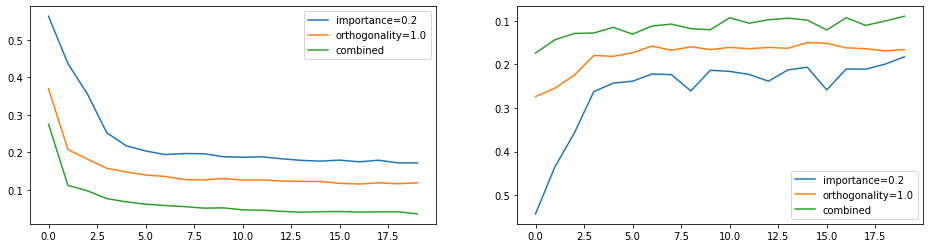

1 0
0.6 0.2
Model: mnist_scratch_importance_1.0_ortho_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


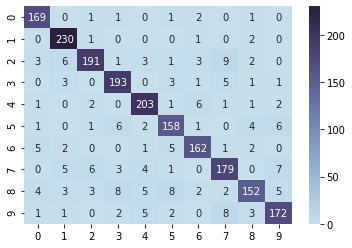

mnist_scratch_importance_0.6_ortho_0.2_conf_mat_run_10_5_experts.png

Experts used by the gate for classification of each digit


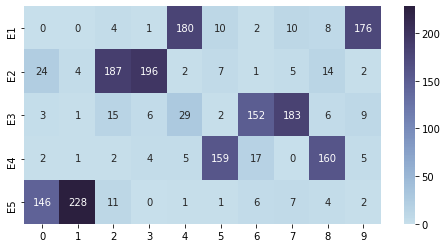

mnist_scratch_importance_0.6_ortho_0.2_class_expert_table_run_10_5_experts.png


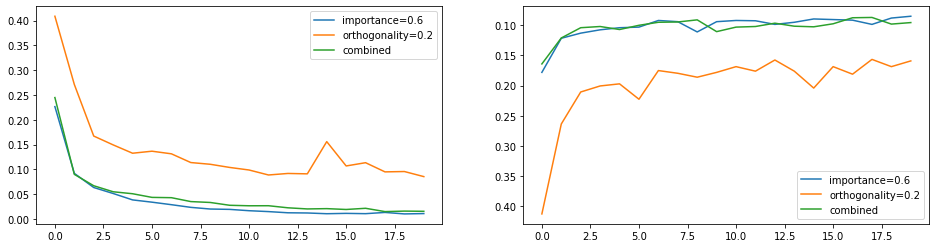

1 1
0.6 0.6
Model: mnist_scratch_importance_1.0_ortho_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


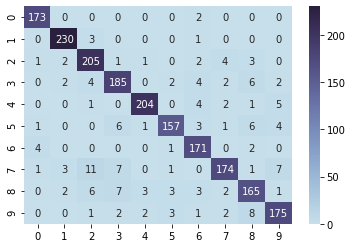

mnist_scratch_importance_0.6_ortho_0.6_conf_mat_run_10_5_experts.png

Experts used by the gate for classification of each digit


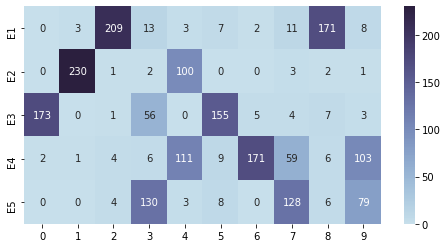

mnist_scratch_importance_0.6_ortho_0.6_class_expert_table_run_10_5_experts.png


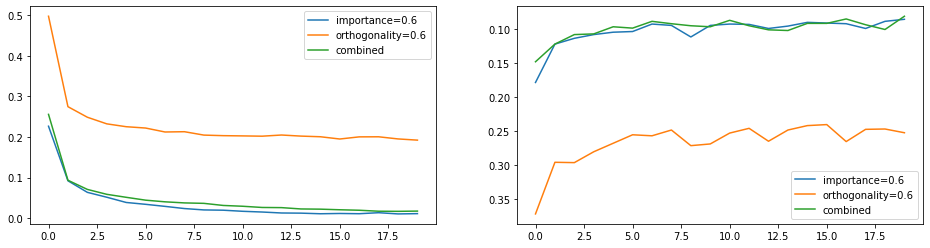

1 2
0.6 1.0
Model: mnist_scratch_importance_1.0_ortho_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


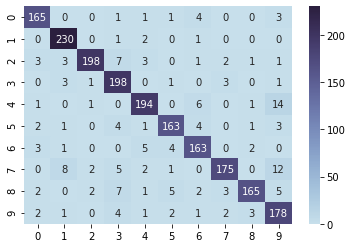

mnist_scratch_importance_0.6_ortho_1.0_conf_mat_run_10_5_experts.png

Experts used by the gate for classification of each digit


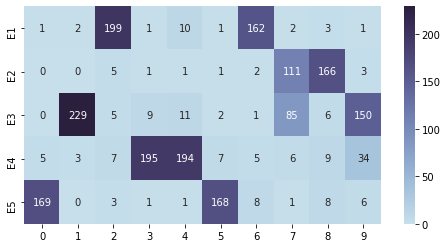

mnist_scratch_importance_0.6_ortho_1.0_class_expert_table_run_10_5_experts.png


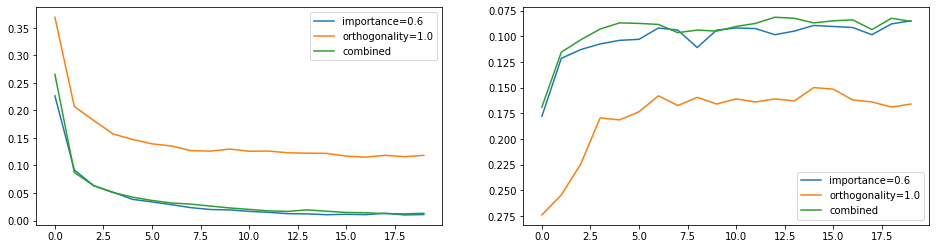

2 0
1.0 0.2
Model: mnist_scratch_importance_1.0_ortho_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


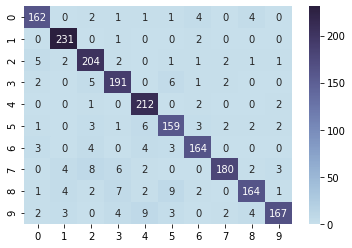

mnist_scratch_importance_1.0_ortho_0.2_conf_mat_run_10_5_experts.png

Experts used by the gate for classification of each digit


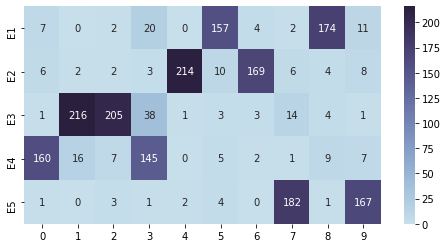

mnist_scratch_importance_1.0_ortho_0.2_class_expert_table_run_10_5_experts.png


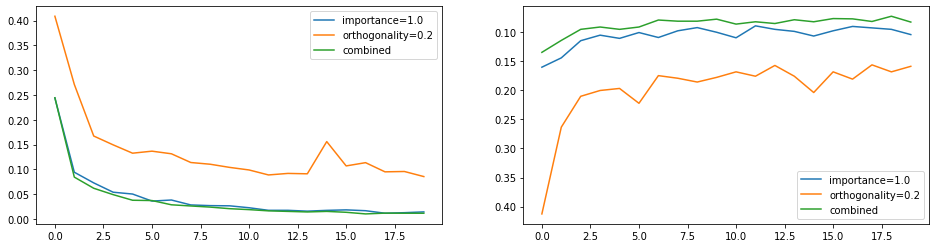

2 1
1.0 0.6
Model: mnist_scratch_importance_1.0_ortho_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


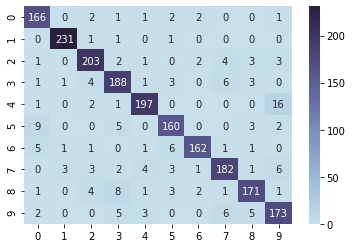

mnist_scratch_importance_1.0_ortho_0.6_conf_mat_run_10_5_experts.png

Experts used by the gate for classification of each digit


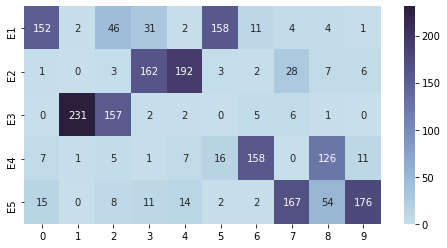

mnist_scratch_importance_1.0_ortho_0.6_class_expert_table_run_10_5_experts.png


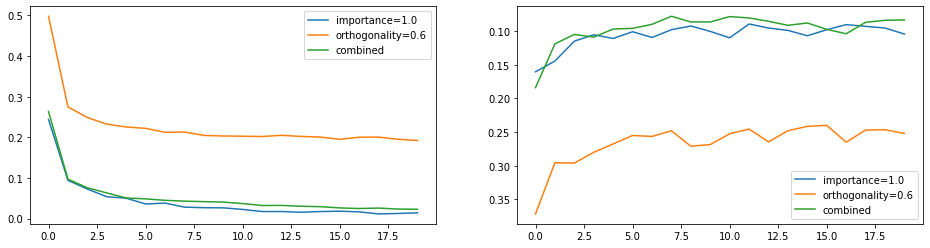

2 2
1.0 1.0
Model: mnist_scratch_importance_1.0_ortho_1.0_10_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


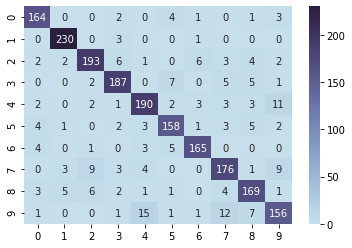

mnist_scratch_importance_1.0_ortho_1.0_conf_mat_run_10_5_experts.png

Experts used by the gate for classification of each digit


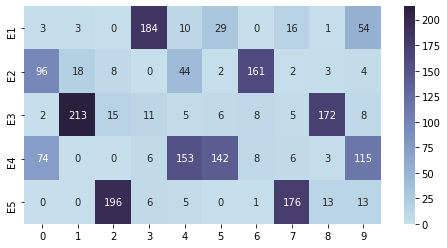

mnist_scratch_importance_1.0_ortho_1.0_class_expert_table_run_10_5_experts.png


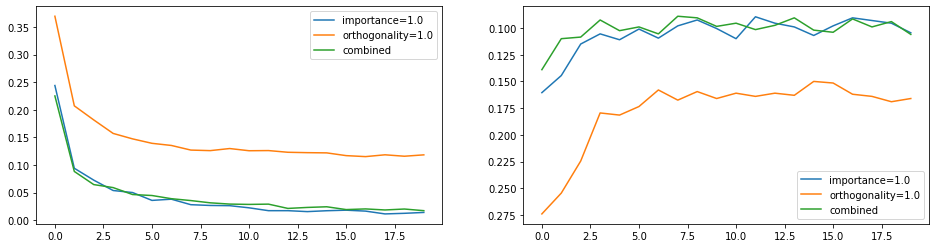

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model_1 = 'mnist_scratch'
m = model_1
w_importance = 1.0
w_ortho = 0.0
plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_models.pt')
models_imp = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

w_importance = 0.0
w_ortho = 1.0
plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_models.pt')
models_ortho = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

w_importance = 1.0
w_ortho = 1.0
total_experts = 5
plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_models.pt')
models_scratch = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
print(plot_file)

i = -1
j = 0
for model in models_scratch:
    j = j%len(w_ortho_range)
    if j==0:
        i += 1

    print(i,j)
    w_importance = w_importance_range[i]
    w_ortho = w_ortho_range[j]
    print(w_importance, w_ortho)
    # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
    # model you build above
    print('Model:', plot_file)

    # Plotting for the model of the first run
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        for images, labels in testloader:
            fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
            images, labels = images.to(device), labels.to(device)
            moe_model = e_val['experts'][total_experts]['model']

            # predict the classes for test data
            pred = moe_model(images)
            pred_labels = torch.argmax(pred, dim=1)

            expert_outputs = moe_model.expert_outputs
            gate_outputs = moe_model.gate_outputs

            # plot the confusion matrix
            print('\nConfusion matrix of predictions of the MNIST test data by MoE expectation model')
            sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1, cmap=cmap, fmt='d')
            image_file = generate_plot_file(m, 'conf_mat_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig1.savefig(os.path.join(fig_path, image_file))
            plt.show()
            print(image_file)

            fig2,ax2 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

            # get the experts selected by the gate for each sample
            pred_gate_labels = torch.argmax(gate_outputs, dim=1)

            # plot the expert selection table
            print('\nExperts used by the gate for classification of each digit')
            class_expert_table = np.asarray([[0] * num_classes]*total_experts)
            for label, expert in zip(labels, pred_gate_labels):
                class_expert_table[expert,label] += 1
            sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d', ax=ax2)

            image_file = generate_plot_file(m, 'class_expert_table_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig2.savefig(os.path.join(fig_path, image_file))
            plt.show()
            print(image_file)
            
            fig3,ax3 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16,4))
            ax3 = ax3.flatten()
            sns.lineplot(x=range(num_epochs), y=1-np.asarray(models_imp[i][e_key]['experts'][total_experts]['history']['accuracy']),ax=ax3[0])
            sns.lineplot(x=range(num_epochs), y=1-np.asarray(models_ortho[j][e_key]['experts'][total_experts]['history']['accuracy']), ax=ax3[0])
            sns.lineplot(x=range(num_epochs), y=1-np.asarray(e_val['experts'][total_experts]['history']['accuracy']), ax=ax3[0])
            ax3[0].legend(['importance='+str(w_importance), 
                        'orthogonality='+str(w_ortho),
                        'combined'])
            
            sns.lineplot(x=range(num_epochs), y=1-np.asarray([v.item() for v in models_imp[i][e_key]['experts'][total_experts]['history']['val_accuracy']]),ax=ax3[1])
            sns.lineplot(x=range(num_epochs), y=1-np.asarray(models_ortho[j][e_key]['experts'][total_experts]['history']['val_accuracy']), ax=ax3[1])
            sns.lineplot(x=range(num_epochs), y=1-np.asarray([v.item() for v in e_val['experts'][total_experts]['history']['val_accuracy']]), ax=ax3[1])
            ax3[1].legend(['importance='+str(w_importance), 
                        'orthogonality='+str(w_ortho),
                        'combined'])
            plt.show()
        j+=1
    

### Analysis mis-classified samples and see how a good task decomposition can facilitate error attribution to the gate or experts

Model: mnist_pretrained_gate_prechosen_10_5_models.pt

Split: [[0, 1], [2, 5], [3, 4], [6, 9], [7, 8]]

Confusion matrix of predictions of the MNIST test data by MoE expectation model


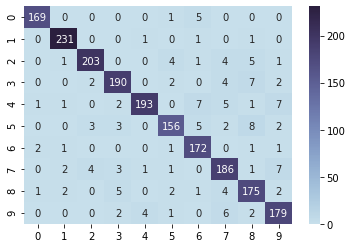

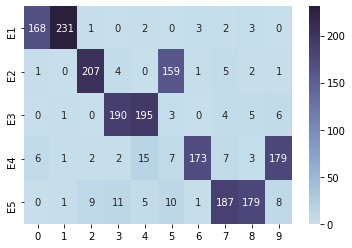


Model mis-classification of 8 is 17


NameError: name 'e_wrong' is not defined

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model_4 = 'mnist_pretrained_gate_prechosen'

m = model_4
total_experts = 5
plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_prechosen = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
print('Model:', plot_file)

for classes_per_expert, model in zip(classes_per_expert_list, models_prechosen):
    print('\nSplit:', classes_per_expert)
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            moe_model = e_val['experts'][total_experts]['model']

            pred = moe_model(images)
            pred_labels = torch.argmax(pred, dim=1)

            expert_outputs = moe_model.expert_outputs
            gate_outputs = moe_model.gate_outputs
            
            pred_gate_labels = torch.argmax(gate_outputs, dim=1)
                        
            # plot the confusion matrix
            fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
            print('\nConfusion matrix of predictions of the MNIST test data by MoE expectation model')
            sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1, cmap=cmap, fmt='d')
            image_file = generate_plot_file(m, 'conf_mat_run_'+classes_per_expert_str(classes_per_expert)+'_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig1.savefig(os.path.join(fig_path, image_file))
            plt.show()
            
            fig2,ax2 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))            
            class_expert_table = np.asarray([[0] * num_classes]*total_experts)
            for label, expert in zip(labels, pred_gate_labels):
                class_expert_table[expert,label] += 1
            sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d', ax=ax2)
            image_file = generate_plot_file(m, 'class_expert_table_'+classes_per_expert_str(classes_per_expert)+'_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig2.savefig(os.path.join(fig_path, image_file))
            plt.show()

            
            for number, e_correct in zip([8,9,5,5],[4,3,1,1]):
                
                num_index = (labels==number)
                
                total = torch.sum(num_index).item()

                num_e_wrong_index = (pred_gate_labels[num_index]==e_correct)==False
                
                model_errors = (pred_labels[num_index]==number)==False
                
                print('\nModel mis-classification of',number,'is',torch.sum(model_errors).item())
                
                gate_errors = torch.sum(num_e_wrong_index).item()
                
                print('\nGate sent', gate_errors, 'out of',total, 'images of', str(number)+'\'s', 
                      'to', 'E'+str(e_wrong+1), 'instead of', 'E'+str(e_correct+1))
                
                num_as_other = images[num_index][num_e_wrong_index]

                print('\nThe',gate_errors,'images sent to the wrong expert are:')
                # create grid of images
                img_grid = torchvision.utils.make_grid(num_as_other, nrow=gate_errors)
                # show images
                fig3, ax3 = plt.subplots(figsize=(18, 2))
                imshow(img_grid, one_channel=True, filename=os.path.join(fig_path,'gate_errors_'+str(number)+'.png'),ax=ax3)
                plt.show()
                
                print('\nThe MoE model mis-classifies these',gate_errors,str(number)+'\'s','as',
                      pred_labels[num_index][num_e_wrong_index].tolist())
                
                # Check if correct expert correctly classifies the gate errors
                expert_correct = moe_model.experts[e_correct]
                e_correct_pred = expert_correct(num_as_other)
                e_correct_labels = torch.argmax(e_correct_pred, dim=1)
                print('\nCorrect','E'+str(e_correct+1),'classifies misclassified images correctly as:', e_correct_labels.tolist(),
                     'Hence the mis-clssification of these images can be attributed to the gate')
                
                # Check if the correct expert classifies without errors
                e_correct_pred = expert_correct(images[num_index])
                e_correct_labels = torch.argmax(e_correct_pred, dim=1)      
                
                fig4,ax4 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
                print('\nConfusion matrix of predictions of the MNIST test data by expert','E'+str(e_correct+1))
                sns.heatmap(confusion_matrix(labels[num_index].cpu(), e_correct_labels.cpu()), annot=True, 
                            xticklabels=torch.unique(e_correct_labels).tolist(),
                            yticklabels=torch.unique(e_correct_labels).tolist(),
                            cmap=cmap, fmt='d',  ax=ax4)
                image_file = generate_plot_file(m, 'conf_mat_expert_'+str(e_correct)+'_'+str(number)+'_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
                fig4.savefig(os.path.join(fig_path, image_file))
                plt.show()
            
                expert_errors_index = (e_correct_labels==number)==False
                expert_errors = torch.sum(expert_errors_index).item()
                if expert_errors > 0:
                    print('\nExpert mis-classifies',expert_errors,number, 'images as',e_correct_labels[expert_errors_index].item(),':')
                    # create grid of images
                    img_grid = torchvision.utils.make_grid(images[num_index][expert_errors_index], nrow=expert_errors)
                    fig5,ax5 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(1.5,1.5))
                    # show images
                    imshow(img_grid, one_channel=True,filename=os.path.join(fig_path,'expert_errors_'+str(number)+'.png'),ax=ax5)
                    plt.show()
                    print('Hence the mis-classification of these errors can be attributed to the expert', 'E'+str(e_correct+1))
                
    break

### Compute the mean negative log likelihood error of mis-classifying commonly mis-classified digit pairs using the pre-trained gate models trained with pre-trained and un-trained experts.

In [44]:
classes_list = [[3,8], [8,3], [4,9], [9,4], [5,8], [8,5]]
results = {'3,8':{}, '8,3':{},'4,9':{},'9,4':{}, '5,8':{}, '8,5':{}}
total_experts = 5
n_runs = 5
for classes in classes_list:
    index_0_1 = torch.where(testset.targets[range(0,testsize)]==classes[0])[0]

    testloader_0_1 = torch.utils.data.DataLoader(torch.utils.data.Subset(torch.utils.data.Subset(testset, range(0,testsize)),index_0_1),
                                                 batch_size=testsize,
                                                 shuffle=True, num_workers=1, pin_memory=True)

    model_2 = 'mnist_pretrained_gate_scratch_same_wts'
    model_5 = 'mnist_pretrained_gate_prechosen_same_wts'

    m1 = model_2
    m2 = model_5
    plot_file = generate_plot_file(m1, str(num_classes)+'_'+str(total_experts)+'_'+str(n_runs)+'_models.pt')
    
    # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
    # model you build above
    models_scratch_10 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
    models_scratch = models_scratch_10[0]
    
    plot_file = generate_plot_file(m2, str(num_classes)+'_'+str(total_experts)+'_models.pt')
    
    # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
    # model you build above
    models_prechosen = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)[1]

    m_key = 'moe_expectation_model'
    moe_model_scratch = models_scratch[m_key]['experts'][total_experts]['model']
    moe_model_prechosen = models_prechosen[m_key]['experts'][total_experts]['model']

    for images, labels in testloader_0_1:
        images, labels = images.to(device), labels.to(device)
        pred_scratch = moe_model_scratch(images)
        pred_prechosen = moe_model_prechosen(images)
        eps=1e-7
        # compute mean negative log likelihood error for digit pairs
        logp = torch.log(torch.div(pred_prechosen[:,classes[0]].reshape(len(labels),1), 
                                   pred_prechosen[:,classes[0]].reshape(len(labels),1)+pred_prechosen[:,classes[1]].reshape(len(labels),1)))
        with torch.no_grad():
            log_error = -1 * np.nan_to_num(logp.cpu().numpy(), neginf=0)
            results[','.join([str(c) for c in classes])]['pre-trained experts'] = log_error.mean()
        
        # compute mean negative log likelihood error for digit pairs
        logp = torch.log(torch.div(pred_scratch[:,classes[0]].reshape(len(labels),1), 
                                   pred_scratch[:,classes[0]].reshape(len(labels),1)+pred_scratch[:,classes[1]].reshape(len(labels),1)))
        with torch.no_grad():
            log_error = -1 * np.nan_to_num(logp.cpu().numpy(), neginf=0)
            results[','.join([str(c) for c in classes])]['un-trained experts'] = log_error.mean()
print('Mean negative log likelihood error of mis-classifying commonly mis-classfied digit pairs')
pprint(results)

Mean negative log likelihood error of mis-classifying commonly mis-classfied digit pairs
{'3,8': {'pre-trained experts': 0.090194434, 'un-trained experts': 0.07918721},
 '4,9': {'pre-trained experts': 0.08958513, 'un-trained experts': 0.23281232},
 '5,8': {'pre-trained experts': 0.03667026, 'un-trained experts': 0.15828235},
 '8,3': {'pre-trained experts': 0.19884956, 'un-trained experts': 0.20240311},
 '8,5': {'pre-trained experts': 0.20628183, 'un-trained experts': 0.15620516},
 '9,4': {'pre-trained experts': 0.18747947, 'un-trained experts': 0.12813157}}
